In [1]:
import gc
import os
import itertools
import pickle
import re
import time
from random import choice, choices
from functools import reduce
from tqdm import tqdm
from itertools import cycle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from functools import reduce
from itertools import cycle
from scipy import stats
from scipy.stats import skew, kurtosis
from sklearn import metrics, model_selection, preprocessing, linear_model, ensemble, decomposition, tree
import lightgbm as lgb
import optuna
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, StackingRegressor
from catboost import CatBoostRegressor
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression


import sys
sys.path.append('../../')
from utils import *

## Prepro: change names to numbers

In [2]:
train_feats = pd.read_csv('../../feature_eng/output/train_double_corr_786feats.csv')
train_score = pd.read_csv('../../data/train_scores.csv')

# train_feats_first10min = pd.read_csv('../../feature_eng/output/train_double_corr_first_10min_786feats.csv')
# train_feats_second10min = pd.read_csv('../../feature_eng/output/train_double_corr_second_10min_786feats.csv')
# train_feats = train_feats.merge(train_feats_first10min, on='id', how='left')
# train_feats = train_feats.merge(train_feats_second10min, on='id', how='left')

if 'score' not in train_feats.columns:
    train_feats = pd.merge(train_feats, train_score, on='id', how='left')

train_feats.replace([np.inf, -np.inf], np.nan, inplace=True)
cols = train_feats.columns

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train_feats['score'])

score_transformed = le.transform(train_feats['score'])

## Keep columns

In [3]:
# Options:
# "count_bursts", "word_sent_parag_agg", "pressed_keys", "paussed_features"
# "segments_visit", "paragraph_ratios", "time_gaps", "cursor_word_changes"
# "punctuation", "key_mouse", "time_feat", "fft", "avg_event_per_minute", 
# "avg_char_deletion_per_minute", "avg_char_insert_per_minute"
# "IKI_word", "IKI_sentence", "IKI_paragraph", "latencies", "IWD"
# 'idle'

endings_to_keep = [
    "count_bursts", "word_sent_parag_agg", "pressed_keys", "paussed_features",
    "segments_visit", "paragraph_ratios", "time_gaps", "cursor_word_changes",
    "punctuation", "key_mouse", "time_feat", "avg_event_per_minute", 
    "avg_char_deletion_per_minute", "avg_char_insert_per_minute",
    "IKI_word", "IKI_sentence", "IKI_paragraph", "latencies", "IWD",
    'idle'
]
endings_to_keep += ["id"]

dir_to_save = "stacking6"
stratification = False
n_jobs = -1
noise = True
iterations = 5
n_splits = 5

try:
    os.mkdir(dir_to_save)
except:
    print('Already exists')
    sys.exit()

# cols_to_keep = [col for col in train_feats.columns if col.endswith(tuple(endings_to_keep)) or col in ['id', 'score']]
cols_to_keep = [col for col in train_feats.columns if any(ending in col for ending in endings_to_keep) or col in ['id', 'score']]

with open(f'{dir_to_save}/feature_list.pkl', 'wb') as f:
    pickle.dump(cols_to_keep, f)

train_feats = train_feats[cols_to_keep]
print(len(train_feats.columns)-2)

836


In [4]:
# Options:
# "count_bursts", "word_sent_parag_agg", "pressed_keys", "paussed_features"
# "segments_visit", "paragraph_ratios", "time_gaps", "cursor_word_changes"
# "punctuation", "key_mouse", "time_feat", "fft", "avg_event_per_minute", 
# "avg_char_deletion_per_minute", "avg_char_insert_per_minute"
# "IKI_word", "IKI_sentence", "IKI_paragraph", "latencies", "IWD"
# 'idle'

endings_1 = ["-count_bursts", "-word_sent_parag_agg"]
feats_1 = [col for col in train_feats.columns if any(ending in col for ending in endings_1)]

endings_2 = ["pressed_keys", "paussed_features", "segments_visit", "paragraph_ratios"]
feats_2 = [col for col in train_feats.columns if any(ending in col for ending in endings_2)]

endings_3 = ["punctuation", "avg_char_deletion_per_minute", "key_mouse", "IKI_word", "IKI_sentence", "IKI_paragraph", "latencies", "IWD", 'idle']
feats_3 = [col for col in train_feats.columns if any(ending in col for ending in endings_3)]

endings_4 = ["time_feat", "word_sent_parag_agg", "time_gaps", "cursor_word_changes", "idle"]
feats_4 = [col for col in train_feats.columns if any(ending in col for ending in endings_4)]

In [5]:
counter = 0
new_columns = {}
for col in cols:
    if col != 'id' and col != 'score':
        new_columns[col] = counter
        counter += 1

train_feats.rename(columns=new_columns, inplace=True)

# Rename columns
feats_1 = [v for k, v in new_columns.items() if k in feats_1]
feats_2 = [v for k, v in new_columns.items() if k in feats_2]
feats_3 = [v for k, v in new_columns.items() if k in feats_3]
feats_4 = [v for k, v in new_columns.items() if k in feats_4]

In [6]:
with open(f'{dir_to_save}/new_col_dict.pkl', 'wb') as f:
    pickle.dump(new_columns, f)

In [7]:
target_col = ['score']
drop_cols = ['id']
train_cols = [col for col in train_feats.columns if col not in target_col + drop_cols]

In [8]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_names):
        self.feature_names = feature_names

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.feature_names]

In [9]:
xgb_params = {'lambda': 0.16, 'alpha': 0.001, 'colsample_bytree': 0.4, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.9, 'subsample': 0.9, 'learning_rate': 0.008, 'n_estimators': 750, 'max_depth': 3}
lgb_params = {'reg_lambda': 7.5, 'reg_alpha': 0.0004, 'colsample_bytree': 0.7, 'colsample_bynode': 0.8, 'subsample': 0.9, 'learning_rate': 0.005, 'max_depth': 15, 'min_child_samples': 13, 'num_leaves': 10, 'n_estimators': 1000}
cat_params = {'iterations': 1250, 'learning_rate': 0.0087, 'depth': 11, 'reg_lambda': 0.0005, 'min_data_in_leaf': 60}

In [12]:
def stack_calc_OOF(x_train, y_train, x_valid, y_valid, iter, split, RANDOM_STATE=42, noise=False):

    # lr_pipeline = make_pipeline(
    #     SimpleImputer(strategy='median'),
    #     MinMaxScaler(feature_range=(-1, 1)),
    #     LinearRegression()
    # )

    svr_pipeline = make_pipeline(
        SimpleImputer(strategy='median'),
        MinMaxScaler(feature_range=(-1, 1)),
        SVR()
    )

    lgb_all_params = {
        "objective": "rmse",
        "metric": "rmse",
        'random_state': RANDOM_STATE,
        "verbosity": -1,
        "n_jobs": -1,
        **lgb_params
    }

    xgb_all_params = {
        'tree_method':'exact',
        'objective': 'reg:squarederror',
        'eval_metric': ['rmse'],
        'seed': RANDOM_STATE,
        'nthread': -1,
        **xgb_params
    }

    cat_all_params = {
        'loss_function': 'RMSE',
        'eval_metric': 'RMSE',
        'random_seed': RANDOM_STATE,
        "task_type":"CPU",
        'silent': True,
        # **cat_params
    }


    estimators = [
        ('lgb1', make_pipeline(FeatureSelector(feats_1), lgb.LGBMRegressor(**lgb_all_params))),
        ('lgb2', make_pipeline(FeatureSelector(feats_2), lgb.LGBMRegressor(**lgb_all_params))),
        ('lgb3', make_pipeline(FeatureSelector(feats_3), lgb.LGBMRegressor(**lgb_all_params))),
        ('lgb4', make_pipeline(FeatureSelector(feats_4), lgb.LGBMRegressor(**lgb_all_params))),
        ('xgb1', make_pipeline(FeatureSelector(feats_1), xgb.XGBRegressor(**xgb_all_params))),
        ('xgb2', make_pipeline(FeatureSelector(feats_2), xgb.XGBRegressor(**xgb_all_params))),
        ('xgb3', make_pipeline(FeatureSelector(feats_3), xgb.XGBRegressor(**xgb_all_params))),
        ('xgb4', make_pipeline(FeatureSelector(feats_4), xgb.XGBRegressor(**xgb_all_params))),
        ('cat1', make_pipeline(FeatureSelector(feats_1), CatBoostRegressor(**cat_all_params))),
        ('cat2', make_pipeline(FeatureSelector(feats_2), CatBoostRegressor(**cat_all_params))),
        ('cat3', make_pipeline(FeatureSelector(feats_3), CatBoostRegressor(**cat_all_params))),
        ('cat4', make_pipeline(FeatureSelector(feats_4), CatBoostRegressor(**cat_all_params))),
        ('svr1', make_pipeline(FeatureSelector(feats_1), svr_pipeline)),
        ('svr3', make_pipeline(FeatureSelector(feats_3), svr_pipeline)),
        ('svr4', make_pipeline(FeatureSelector(feats_4), svr_pipeline)),
    ]

    model = StackingRegressor(
        estimators=estimators,
        final_estimator=LinearRegression(),
        passthrough=False,
    )

    if noise:
        y_train = y_train + np.random.normal(0, 0.25, y_train.shape)
    model.fit(x_train, y_train.values.ravel())
    with open(f'./{dir_to_save}/stack_iter{iter}_split{split}_val.pkl', 'wb') as f:
        pickle.dump(model, f)

    # Predict
    valid_predict = model.predict(x_valid)
    print(f'RMSE: {mean_squared_error(y_valid, valid_predict, squared=False)}')

    # Return OOFs
    return valid_predict

In [13]:
OOF_SCORE = np.zeros(len(train_feats))

models_dict = {}
preds_dict = {}
count = 0
for _ in train_feats['id'].unique():
    preds_dict[count] = []
    count+=1


for i in range(iterations):

    print(f'Iterations: {i+1}/{iterations}')

    if stratification:
        kf = model_selection.StratifiedKFold(n_splits=n_splits, random_state=41 + i, shuffle=True)
        j = 0
        for fold, (train_idx, valid_idx) in enumerate(kf.split(train_feats, score_transformed)):
            
            X_train, y_train = train_feats.iloc[train_idx][train_cols], train_feats.iloc[train_idx][target_col]
            X_valid, y_valid = train_feats.iloc[valid_idx][train_cols], train_feats.iloc[valid_idx][target_col]

            valid_predict = stack_calc_OOF(X_train, y_train, X_valid, y_valid, i, j, RANDOM_STATE=41 + i)

            OOF_SCORE[valid_idx] += valid_predict / iterations
            j+=1

    else:
        kf = model_selection.KFold(n_splits=n_splits, random_state=41 + i, shuffle=True)
        j = 0
        for fold, (train_idx, valid_idx) in enumerate(kf.split(train_feats)):
            
            X_train, y_train = train_feats.iloc[train_idx][train_cols], train_feats.iloc[train_idx][target_col]
            X_valid, y_valid = train_feats.iloc[valid_idx][train_cols], train_feats.iloc[valid_idx][target_col]

            valid_predict = stack_calc_OOF(X_train, y_train, X_valid, y_valid, i, j, RANDOM_STATE=41 + i)

            OOF_SCORE[valid_idx] += valid_predict / iterations
            j+=1

Iterations: 1/5
RMSE: 0.6107574851769296
RMSE: 0.6175829431087517
RMSE: 0.6185082483984802
RMSE: 0.5804525089238554
RMSE: 0.5844710186963041
Iterations: 2/5
RMSE: 0.5368743759040431
RMSE: 0.6438471548390406
RMSE: 0.601986611758062
RMSE: 0.6385543505639001
RMSE: 0.5951839329912353
Iterations: 3/5
RMSE: 0.5757385904373723
RMSE: 0.5796303705418892
RMSE: 0.6282228445388249
RMSE: 0.6095514608953272
RMSE: 0.6445783316675274
Iterations: 4/5
RMSE: 0.6389803509053026
RMSE: 0.582898665224091
RMSE: 0.5827736961510873
RMSE: 0.6267149087492901
RMSE: 0.6146777202060799
Iterations: 5/5
RMSE: 0.6024264988049487
RMSE: 0.6095172824476423
RMSE: 0.5920679813158924
RMSE: 0.6115653062807853
RMSE: 0.6129765521482952


In [17]:
print('OOF metric Stack = {:.5f}'.format(metrics.mean_squared_error(train_feats[target_col], 
                                                                   OOF_SCORE,
                                                                   squared=False)))

OOF metric Stack = 0.60262


In [15]:
# import pickle

# with open(f'{dir_to_save}/OOF_base_xgb.pkl', 'wb') as f:
#     pickle.dump(OOF_SCORE, f)

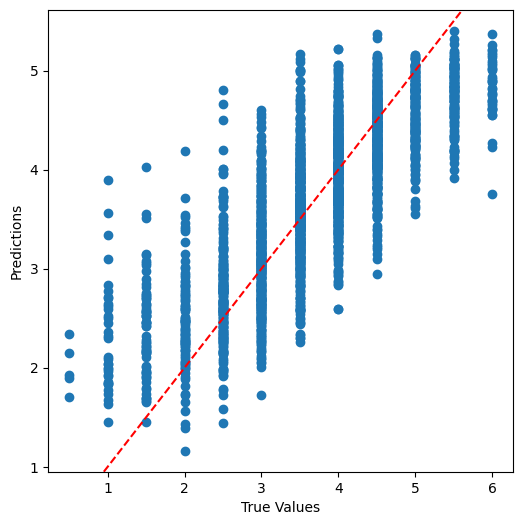

In [18]:
f, ax = plt.subplots(figsize=(6, 6))
ax.scatter(train_feats['score'], OOF_SCORE)
add_identity(ax, color='r', ls='--')
# ax.scatter(stds, train_scores_df['score']-means)
plt.xlabel('True Values')
plt.ylabel('Predictions')

plt.show()